In [1]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import os
import scipy.io.wavfile
import numpy as np
import sys
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
#import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization, Input, Flatten, Dropout, Activation
from tensorflow.keras.utils import to_categorical
import np_utils
import live_plot
from tensorflow.keras import optimizers

Populating the interactive namespace from numpy and matplotlib


## Data Set Preparing

In [2]:
mylist = []
for path, subdirs, files in os.walk("data"):
    for name in files:
        mylist.append(os.path.join(path, name))

## Waveform of an Audio File

In [3]:
data, sampling_rate = librosa.load("03-01-01-01-01-01-01.wav")

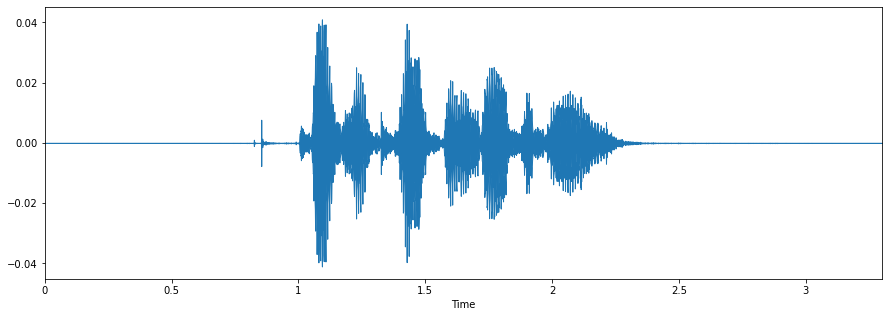

In [4]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

## Spectrogram

C:\Users\ertug\AppData\Local\Temp/ipykernel_20416/1312906718.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read("data/Actor_01/03-01-01-01-01-01-01.wav")
C:\Users\ertug\AppData\Local\Temp/ipykernel_20416/1312906718.py:12: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


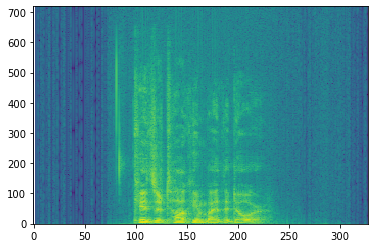

In [5]:
sr,x = scipy.io.wavfile.read("data/Actor_01/03-01-01-01-01-01-01.wav")
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)
nn = range(nwin, len(x), nstep)
X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.show()

## Extract Features from Audio Using "Librosa"

In [6]:
def get_emotion(file_path):
        item = file_path.split('\\')[-1]
        if item[6:-16]=='02' and int(item[18:-4])%2==0:
            return 'female_calm'
        elif item[6:-16]=='02' and int(item[18:-4])%2==1:
            return 'male_calm'
        elif item[6:-16]=='03' and int(item[18:-4])%2==0:
            return 'female_happy'
        elif item[6:-16]=='03' and int(item[18:-4])%2==1:
            return 'male_happy'
        elif item[6:-16]=='04' and int(item[18:-4])%2==0:
            return 'female_sad'
        elif item[6:-16]=='04' and int(item[18:-4])%2==1:
            return 'male_sad'
        elif item[6:-16]=='05' and int(item[18:-4])%2==0:
            return 'female_angry'
        elif item[6:-16]=='05' and int(item[18:-4])%2==1:
            return 'male_angry'
        elif item[6:-16]=='06' and int(item[18:-4])%2==0:
            return 'female_fearful'
        elif item[6:-16]=='06' and int(item[18:-4])%2==1:
            return 'male_fearful'
        elif item[6:-16]=='01' and int(item[18:-4])%2==0:
            return 'female_neutral'
        elif item[6:-16]=='01' and int(item[18:-4])%2==1:
            return 'male_neutral'
        elif item[6:-16]=='07' and int(item[18:-4])%2==0:
            return 'female_disgusted'
        elif item[6:-16]=='07' and int(item[18:-4])%2==1:
            return 'male_disgusted'
        elif item[6:-16]=='08' and int(item[18:-4])%2==0:
            return 'female_surprised'
        elif item[6:-16]=='08' and int(item[18:-4])%2==1:
            return 'male_surprised'
        elif item[:1]=='a':
            return 'male_angry'
        elif item[:1]=='h':
            return 'male_happy'
        elif item[:1]=='n':
            return 'male_neutral'
        elif item[:2]=='sa':
            return 'male_sad'

In [7]:
df = pd.DataFrame(columns=['feature','emotion'])
bookmark=0
for index,y in enumerate(mylist):
    X, sample_rate = librosa.load(y, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    emotion = get_emotion(y)
    df.loc[bookmark] = [feature, emotion]
    bookmark=bookmark+1 

In [22]:
df[:10]

,feature,emotion
0,"[-18.664696, -20.0252, -26.280422, -26.582205,...",male_angry
1,"[-25.459312, -23.82562, -22.953722, -22.429497...",male_happy
2,"[-23.96262, -24.250711, -24.695234, -26.13461,...",male_neutral
3,"[-27.471874, -26.071787, -26.824247, -27.46634...",male_sad
4,"[-65.80097, -65.80097, -65.80097, -65.80097, -...",male_neutral
5,"[-61.84994, -62.89504, -63.830635, -60.552586,...",male_neutral
6,"[-65.81886, -65.81886, -65.81886, -65.81886, -...",male_neutral
7,"[-66.05848, -66.05848, -66.05848, -66.05848, -...",male_neutral
8,"[-70.26777, -70.26777, -70.26777, -70.26777, -...",male_calm
9,"[-67.55739, -67.55739, -67.55739, -67.55739, -...",male_calm


In [8]:
feature_df = pd.DataFrame(df['feature'].values.tolist())
labelled_df = pd.concat([feature_df,df['emotion']], axis=1)
df_cleaned = labelled_df.dropna(0)
shuffled_df = df_cleaned.sample(frac=1).reset_index(drop=True)
shuffled_df = shuffled_df.loc[~shuffled_df['emotion'].isin(['male_neutral', 'male_disgusted', 'male_surprised', 'female_neutral', 'female_disgusted', 'female_surprised'])]

C:\Users\ertug\AppData\Local\Temp/ipykernel_20416/3741121088.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df_cleaned = labelled_df.dropna(0)


In [24]:
df_cleaned[:10]

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
1,-25.459312,-23.825621,-22.953722,-22.429497,-24.174665,-24.606770,-24.429699,-24.255440,-13.446604,-4.582471,...,-24.194397,-23.196415,-23.863752,-24.454817,-23.471224,-24.883118,-24.358156,-23.878014,-25.733727,male_happy
2,-23.962620,-24.250711,-24.695234,-26.134609,-26.347507,-25.856962,-24.621765,-25.570272,-25.602043,-25.633371,...,-9.571778,-7.391902,-6.189562,-5.823820,-6.583437,-6.108576,-5.643084,-5.841223,-5.274676,male_neutral
8,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm
9,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_calm
10,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_calm
12,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_calm
13,-69.243256,-69.243256,-69.243256,-69.243256,-68.901970,-67.983002,-68.089203,-67.897331,-65.258011,-67.170975,...,-57.185970,-61.188725,-67.108391,-67.508125,-66.245537,-68.733047,-69.243256,-69.243256,-69.243256,male_calm
14,-73.254967,-73.254967,-73.254967,-73.254967,-68.774429,-69.380402,-73.254967,-73.254967,-73.254967,-73.254967,...,-50.884079,-55.666733,-54.600010,-53.439114,-56.300125,-57.458267,-58.767071,-59.836510,-58.409870,male_calm
15,-70.746513,-70.746513,-70.025284,-69.131271,-70.746513,-70.746513,-70.746513,-70.746513,-70.746513,-70.746513,...,-70.746513,-70.746513,-70.079247,-69.590454,-69.202751,-70.159462,-70.445366,-68.199043,-67.414200,male_calm
18,-65.427315,-65.427315,-65.261780,-65.427315,-65.427315,-65.427315,-65.027588,-65.404327,-65.427315,-58.999031,...,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,male_happy


In [9]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.drop('emotion', axis =1), shuffled_df['emotion'], test_size=0.2, random_state=0, shuffle = True)

In [10]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
np.save('label_classes.npy', lb.classes_)

In [11]:
x_train_exp = np.expand_dims(X_train, axis=2)
x_test_exp = np.expand_dims(X_test, axis=2)

## Sentiment Analysis Model

In [12]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_train_exp.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 259, 256)          1536      
                                                                 
 activation (Activation)     (None, 259, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 259, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 259, 128)          0         
                                                                 
 dropout (Dropout)           (None, 259, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 128)          0         
 )                                                               
                                                        

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [15]:
history=model.fit(x_train_exp, y_train, batch_size=16, epochs=200, validation_data=(x_test_exp, y_test), verbose=0)

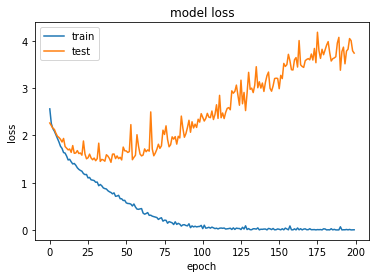

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('result.png')

In [17]:
train_result = model.evaluate(x_train_exp, y_train, verbose=1)
test_result = model.evaluate(x_test_exp, y_test, verbose=1)

print("train acc","%s: %.2f%%" % (model.metrics_names[1], train_result[1]*100))
print("test acc","%s: %.2f%%" % (model.metrics_names[1], test_result[1]*100))

5/5 [==============================] - 0s 15ms/step - loss: 3.7411 - accuracy: 0.5000
train acc accuracy: 99.66%
test acc accuracy: 50.00%


## Test the Predictions

In [18]:
preds = model.predict(x_test_exp, batch_size=512, verbose=1)
preds_mod = preds.argmax(axis=1)
preds_flat = preds_mod.astype(int).flatten()
preds_transformed = (lb.inverse_transform((preds_flat)))
pred_df = pd.DataFrame({'predictedvalues': preds_transformed})
actual_values = y_test.argmax(axis=1)
actual_values_mod = actual_values.astype(int).flatten()
actual_values_mod_transformed = (lb.inverse_transform((actual_values_mod)))
actual_df = pd.DataFrame({'actualvalues': actual_values_mod_transformed})
final_df = actual_df.join(pred_df)
final_df.head(10)

1/1 [==============================] - 0s 144ms/step


,actualvalues,predictedvalues
0,female_fearful,female_sad
1,female_sad,female_calm
2,female_sad,female_calm
3,female_calm,male_calm
4,male_fearful,male_fearful
5,male_angry,male_angry
6,male_happy,male_angry
7,female_fearful,female_fearful
8,female_fearful,female_calm
9,male_sad,male_sad


In [19]:
#final_df.to_excel("data.xlsx")